In [1]:
# To start this notebook with more than one thread, change the extension setting in vs, search for thread,
# and change the Max Threads as well as settings.json.
# This will speed up the computations for running multiple chains. 

# Ensure that Julia was launched with an appropriate number of threads
println(Threads.nthreads())
nr_chains = 4 # number of chains to sample, corresponding to the threads
results_dir = "results_section_6_3"

4


"results_section_6_3"

In [2]:
# using Pkg
# Pkg.add("Turing")
using Plots # to plot things
using Random, Distributions # generate random noise
using LinearAlgebra # identity matrix
using Turing # sampling package
using StatsPlots
using StatsBase # for defining customized distributions 

using QuadGK
using BasicBSpline
using LaTeXStrings

using Optim # for ML and MAP estimation 

# Pkg.add("AdaptiveMCMC")
using AdaptiveMCMC # for using adaptive MCMC sampling
using ProgressMeter # to use progress track for sampling
using Dates # to measure computational time 

using Printf  # Import Printf for formatted output
using FlexiMaps # Provide flexible mapping functionalities, particularly useful for data processing tasks

using SparseArrays

# import Pkg; Pkg.add("ImageTransformations")
using Images, FileIO
using ImageTransformations

include("../src/Mesh_fun.jl")
include("../src/FE_fun.jl")
include("../src/SIACMatrix.jl")

PostProcess (generic function with 1 method)

# Problem setup

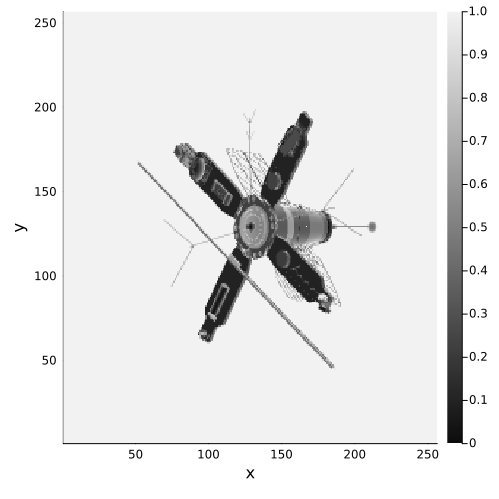

"/Users/tongtongli/Desktop/UMBC/240801BayesianSIAC/code/250902code_TL/notebooks/results_section_6_3/sattelite_original.png"

In [4]:
# parameters
N = 256 # number of pixels in every direction 
γ = 0.015 # blurring parameter (Gaussian convolution kernel) 
σ² = 1e-5 # variance of the i.i.d. complex Gaussian noise added to the measurements 

# Load and resize
img = load("satellite.png")
img_resized = imresize(img, (N, N))                     # Resize
X = Float64.(channelview(Gray.(img_resized)))           # Convert to Float64 matrix
X = reshape(X, N, N)                                     # Ensure shape (N,N)

# show image 
p1 = heatmap(1 .- X, colorbar=true, c=:grays, size=(500,500), xlabel="x", ylabel="y")
display(p1)
savefig(p1, joinpath(results_dir, "sattelite_original.png"))

In [5]:
# 1d forward operator: Gaussian blurring
function construct_F_deconvolution(n::Int, γ::Float64)
    # Define grid
    x = LinRange(0, 1, n)
    
    # Define Gaussian kernel function
    kernel(t) = exp.(-t.^2 ./ (2γ^2)) ./ sqrt(2π*γ^2)
    
    # Create matrix: kernel(x_i - x_j)
    F = [kernel(x[i] - x[j]) for i in 1:n, j in 1:n]
    
    # Normalize by 1/n
    return F ./ n
end

construct_F_deconvolution (generic function with 1 method)

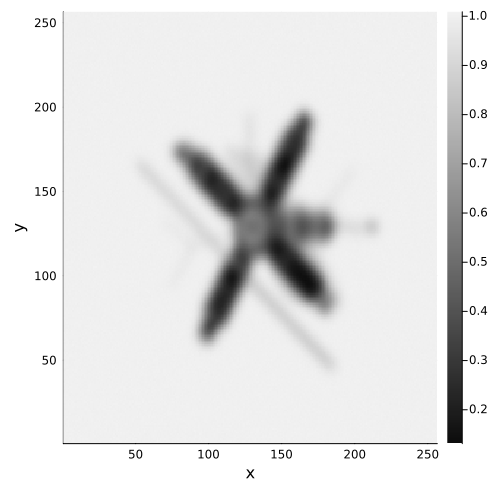

"/Users/tongtongli/Desktop/UMBC/240801BayesianSIAC/code/250902code_TL/notebooks/results_section_6_3/sattelite_blurred.png"

In [6]:
# forward operator
F_1d = construct_F_deconvolution(N, γ)
Random.seed!(123)

# noise: i.i.d. real Gaussian noise
noise = sqrt(σ² / 2) * randn(N, N)

# noisy data
Y = F_1d * X * F_1d' + noise

# show image 
p2 = heatmap(1 .- Y, colorbar=true, c=:grays, size=(500,500), xlabel="x", ylabel="y")
display(p2)
savefig(p2, joinpath(results_dir, "sattelite_blurred.png"))

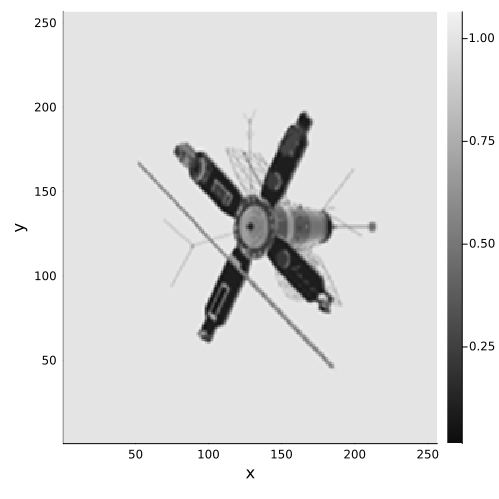

"/Users/tongtongli/Desktop/UMBC/240801BayesianSIAC/code/250902code_TL/notebooks/results_section_6_3/sattelite_filtered.png"

In [7]:
# SIAC matrix
# Piecewise Polynomial Setup for SIAC Filter
p = 1
xx = collect(LinRange(0,1,N))
# Create SIAC Matrix, with periodic boundary treatment
Ffil = global_SIAC_Mat(p, xx, boundaryTreatment="periodic")
Ffil_sparse = sparse(Ffil)

# filtered image
X_filtered = Ffil_sparse * X * Ffil_sparse'
p3 = heatmap(1 .- X_filtered, colorbar=true, c=:grays, size=(500,500), xlabel="x", ylabel="y")
display(p3)
savefig(p3, joinpath(results_dir, "sattelite_filtered.png"))

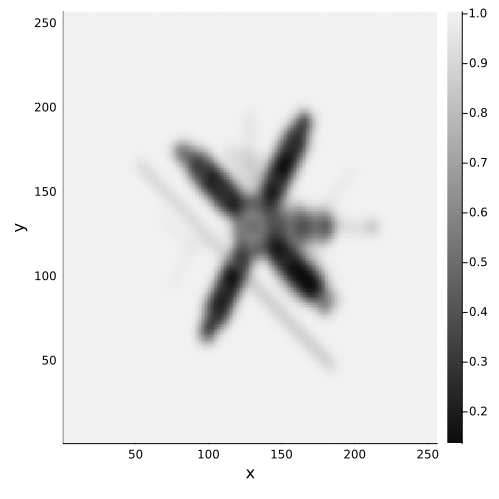

"/Users/tongtongli/Desktop/UMBC/240801BayesianSIAC/code/250902code_TL/notebooks/results_section_6_3/sattelite_filteredY.png"

In [8]:
# SIAC matrix
# Piecewise Polynomial Setup for SIAC Filter
p = 1
xx = collect(LinRange(0,1,N))
# Create SIAC Matrix, with periodic boundary treatment
Ffil = global_SIAC_Mat(p, xx, boundaryTreatment="periodic")
Ffil_sparse = sparse(Ffil)

# filtered image
Y_filtered = Ffil_sparse * Y * Ffil_sparse'
p4 = heatmap(1 .- Y_filtered, colorbar=true, c=:grays, size=(500,500), xlabel="x", ylabel="y")
display(p4)
savefig(p4, joinpath(results_dir, "sattelite_filteredY.png"))

# MAP estimate

We will compute the MAP estimates by the Block Coordinate Descent (BCD) algorithm.

## BCD

In [9]:
function BCD_2d(F_1d, Y, R_1d, c, d; max_iter=1000, min_iter=10, abstol=1e-4, reltol=1e-2, grad_steps=5, quiet=false)
    
    # Sizes
    n = size(F_1d, 1)

    # Precomputed operations
    function FTAF(X, alpha)
        return alpha * vec(F_1d' * (F_1d * X * F_1d') * F_1d)
    end

    function RTBR(X, beta)
        return beta * vec(R_1d' * (R_1d * X * R_1d') *R_1d)
    end

    function G(X, alpha, beta)
        return FTAF(X, alpha) + RTBR(X, beta)
    end

    function b(Y, alpha)
        return alpha * vec(F_1d' * Y * F_1d)
    end

    # Initialization
    alpha = 1.0
    beta = 1.0
    Mu = zeros(n, n)
    Mu_old = copy(Mu)

    # History tracking
    history = Dict(:abs_error => Float64[], :rel_error => Float64[])

    if !quiet
        @printf("%4s\t%12s\t%12s\t%12s\t%12s\n", "iter", "abs error", "abs tol", "rel error", "rel tol")
    end

    for iter = 1:max_iter
        # Step 1: update Mu with fixed alpha, B1, B2
        r = b(Y, alpha) - G(Mu, alpha, beta)
        for _ = 1:grad_steps
            Rmat = reshape(r, n, n)
            grad = G(Rmat, alpha, beta)
            gamma = norm(r)^2 / dot(r, grad)
            Mu += gamma * Rmat
            r -= gamma * grad
        end

        # Step 2: update alpha
        residual = F_1d * Mu * F_1d' - Y
        alpha = (n^2 + 2*c) / (norm(vec(residual))^2 + 2*d)

        # Step 3: update B1 and B2
        residual_b = R_1d * Mu * R_1d'
        beta = (n^2 + 2*c) / (norm(vec(residual_b))^2 + 2*d)

        # Error tracking
        abs_err = norm(vec(Mu - Mu_old))^2
        rel_err = abs_err / norm(vec(Mu_old))^2
        push!(history[:abs_error], abs_err)
        push!(history[:rel_error], rel_err)
        Mu_old .= Mu

        # Display
        if !quiet
            @printf("%4d\t%12.4e\t%12.4e\t%12.4e\t%12.4e\n", iter, abs_err, abstol, rel_err, reltol)
        end

        # Convergence check
        if iter > min_iter && abs_err < abstol && rel_err < reltol
            break
        end
    end

    return Mu, alpha, beta, history
end

BCD_2d (generic function with 1 method)

In [10]:
# regularization operator
R_1d = Matrix(1.0I, N, N) - Ffil

c = 1.0
d = 1.0e-2

# Obtain MAP estimate using BCD algorithm
tBCD = @elapsed begin # execution time

    fx_BCD, aalpha, bbeta, history = BCD_2d(F_1d, Y, R_1d, c, d; quiet=false ); 
    
end

iter	   abs error	     abs tol	   rel error	     rel tol
   1	  2.4698e+03	  1.0000e-04	         Inf	  1.0000e-02
   2	  1.1211e+00	  1.0000e-04	  4.5391e-04	  1.0000e-02
   3	  1.0973e-03	  1.0000e-04	  4.4691e-07	  1.0000e-02
   4	  8.3052e-04	  1.0000e-04	  3.3810e-07	  1.0000e-02
   5	  1.0200e-03	  1.0000e-04	  4.1509e-07	  1.0000e-02
   6	  7.9543e-04	  1.0000e-04	  3.2358e-07	  1.0000e-02
   7	  9.8443e-04	  1.0000e-04	  4.0034e-07	  1.0000e-02
   8	  7.7452e-04	  1.0000e-04	  3.1487e-07	  1.0000e-02
   9	  9.6084e-04	  1.0000e-04	  3.9051e-07	  1.0000e-02
  10	  7.5986e-04	  1.0000e-04	  3.0873e-07	  1.0000e-02
  11	  9.4343e-04	  1.0000e-04	  3.8322e-07	  1.0000e-02
  12	  7.4881e-04	  1.0000e-04	  3.0408e-07	  1.0000e-02
  13	  9.2977e-04	  1.0000e-04	  3.7748e-07	  1.0000e-02
  14	  7.4003e-04	  1.0000e-04	  3.0037e-07	  1.0000e-02
  15	  9.1853e-04	  1.0000e-04	  3.7274e-07	  1.0000e-02
  16	  7.3275e-04	  1.0000e-04	  2.9728e-07	  1.0000e-02
  17	  9.0889e-04	  1.0000e-04	

8.149303542

In [11]:
aalpha

153691.78638976373

In [12]:
bbeta

3.27678240196699e6

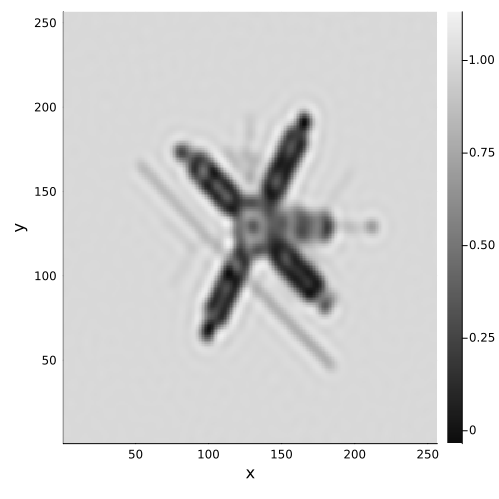

"/Users/tongtongli/Desktop/UMBC/240801BayesianSIAC/code/250902code_TL/notebooks/results_section_6_3/sattelite_BCD.png"

In [13]:
# show image 
map=heatmap(1 .- fx_BCD, colorbar=true, c=:grays, size=(500,500), xlabel="x", ylabel="y")
display(map)
savefig(map, joinpath(results_dir, "sattelite_BCD.png"))